<a href="https://colab.research.google.com/github/YonahJ/SCI/blob/main/ABM/modelling_cultural_evolution_part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelling cultural evolution part I

For these next three sessions, I will be following a recently released book by Alberto Acerbi, Alex Mesoudi, and Marco Smolla called *Individual-based models of cultural evolution: A step-by-step guide using R*. Now, before the alarm bells start ringing, individual-based models is just another term for agent-based models and I've converted their *R* code into Python. 

I encourage you to go away and have a look at this book (especially if you prefer R to Python). It's really great and I think it provides a very intuitive understanding of how to approach ABMs in a step-wise fashion. Where possible I've tried to follow Acerbi et al verbatim, both in terms of text and code structure, but there will inevitably be some deviations given we're dealing with two different programming languages.

This means that some of the code here *will not necessarily be the most efficient way* of achieving these aims in Python. In the next lab session, I will come back to this issue, and show you how different ways of coding up the same model can lead to drastic differences in runtime.

## 1.1	Initialising the simulation
Here we will simulate a case where $N$ individuals each possess one of two mutually exclusive cultural traits. These alternative traits are denoted $A$ and $B$. For example, $A$ might be eating a vegetarian diet, and $B$ might be eating a non-vegetarian diet. In reality, traits are seldom clear-cut (e.g. what about pescatarians?), but models are designed to cut away all the complexity to give tractable answers to simplified situations.

Our model has non-overlapping generations. In each generation, all $N$ individuals are replaced with $N$ new individuals. Again, this is unlike any real biological group but provides a simple way of simulating change over time. Generations here could correspond to biological generations, but could equally be ‘cultural generations’ (or learning episodes), which might be much shorter.

Each new individual of each new generation picks a member of the previous generation at random and copies their cultural trait. This is known as unbiased oblique cultural transmission. ‘Unbiased’ refers to the fact that traits are copied entirely at random. The term ‘oblique’ means that members of one generation learn from those of the previous, non-overlapping, generation. This is different from, for example, horizontal cultural transmission, where individuals copy members of the same generation, and vertical cultural transmission, where offspring copy their biological parents.

If we assume that the two cultural traits are transmitted in an unbiased way, what does that mean for the average trait frequency in the population? To answer this question, we must track the proportion of individuals who possess trait $A$ over successive generations. We will call this proportion $p$. We could also track the proportion who possess trait $B$, but this will always be $1−p$ given that the two traits are mutually exclusive. For example, if $70\%$ of the population have trait $A (p=0.7)$, then the remaining $30\%$ must have trait $B$ (i.e. $1−p=1−0.7=0.3$).

The output of the model will be a plot showing p over all generations up to the last generation. Generations (or time steps) are denoted by $t$, where generation one is $t=1$, generation two is $t=2$, up to the last generation $t=t_{max}$.

First, we need to specify the fixed parameters of the model. These are quantities that we decide on at the start and do not change during the simulation. In this model these are `N` (the number of individuals) and `t_max` (the number of generations). Let's start with `N = 100` and `t_max = 200`:

In [1]:
N = 100
t_max = 200

Now we need to create our individuals. The only information we need to keep about our individuals is their cultural trait ($A$ or $B$). We'll call `population` the data structure containing the individuals. The type of data structure I have chosen here is a dictionary. The code below uses `random.choice` to randomly select a cultural trait for each agent `i` in the population.

In [2]:
import random
population = {i:random.choice(['A','B']) for i in range(0,N)}

We can see the cultural traits of our population by simply entering its name in the cell below:

In [3]:
population

{0: 'B',
 1: 'B',
 2: 'B',
 3: 'B',
 4: 'A',
 5: 'B',
 6: 'B',
 7: 'B',
 8: 'A',
 9: 'B',
 10: 'B',
 11: 'A',
 12: 'A',
 13: 'B',
 14: 'B',
 15: 'B',
 16: 'B',
 17: 'B',
 18: 'B',
 19: 'B',
 20: 'B',
 21: 'B',
 22: 'A',
 23: 'A',
 24: 'A',
 25: 'A',
 26: 'B',
 27: 'A',
 28: 'A',
 29: 'B',
 30: 'B',
 31: 'B',
 32: 'A',
 33: 'B',
 34: 'A',
 35: 'B',
 36: 'A',
 37: 'B',
 38: 'B',
 39: 'B',
 40: 'A',
 41: 'B',
 42: 'A',
 43: 'A',
 44: 'B',
 45: 'A',
 46: 'B',
 47: 'A',
 48: 'A',
 49: 'A',
 50: 'A',
 51: 'B',
 52: 'A',
 53: 'B',
 54: 'A',
 55: 'B',
 56: 'B',
 57: 'A',
 58: 'B',
 59: 'A',
 60: 'B',
 61: 'A',
 62: 'A',
 63: 'B',
 64: 'B',
 65: 'B',
 66: 'A',
 67: 'A',
 68: 'B',
 69: 'A',
 70: 'B',
 71: 'A',
 72: 'A',
 73: 'B',
 74: 'B',
 75: 'A',
 76: 'A',
 77: 'A',
 78: 'A',
 79: 'B',
 80: 'A',
 81: 'B',
 82: 'A',
 83: 'B',
 84: 'A',
 85: 'A',
 86: 'B',
 87: 'B',
 88: 'B',
 89: 'A',
 90: 'B',
 91: 'A',
 92: 'A',
 93: 'A',
 94: 'A',
 95: 'A',
 96: 'B',
 97: 'B',
 98: 'B',
 99: 'A'}

As expected, we have a dictionary with a key (which corresponds to a specific agent) and a value (which corresponds a specific agent's cultural trait).

You can also see the trait of a specific agent by typing in a number between 0 and 99. For example, individual 3's trait can be retrieved by typing:

In [4]:
population[3]

'B'

This should match the fourth row in the dictionary above.

We also need a dictionary to record the output of our simulation. This allows us to track the trait frequency $p$ in each generation. Here, we create a dictionary where each timestep up to `t_max` receives the value `0.0`. Our goal during the simulation is to update this dictionary at each generation with the trait frequency:

In [5]:
output = {g:0.0 for g in range(0,t_max)}

We can, however, fill in the first value of `p` for our already-created first generation of individuals, held in `population`. The command below sums the number of $A$s in `population` and divides by $N$ to get a proportion out of 1 rather than an absolute number. It then puts this proportion in the `output` dictionary at the first generation `0`. We can again write the name of the dictionary, `output` to see that it worked.

In [6]:
total_A = sum(value == 'A' for value in population.values())
output.update({0:total_A/N})
output

{0: 0.47,
 1: 0.0,
 2: 0.0,
 3: 0.0,
 4: 0.0,
 5: 0.0,
 6: 0.0,
 7: 0.0,
 8: 0.0,
 9: 0.0,
 10: 0.0,
 11: 0.0,
 12: 0.0,
 13: 0.0,
 14: 0.0,
 15: 0.0,
 16: 0.0,
 17: 0.0,
 18: 0.0,
 19: 0.0,
 20: 0.0,
 21: 0.0,
 22: 0.0,
 23: 0.0,
 24: 0.0,
 25: 0.0,
 26: 0.0,
 27: 0.0,
 28: 0.0,
 29: 0.0,
 30: 0.0,
 31: 0.0,
 32: 0.0,
 33: 0.0,
 34: 0.0,
 35: 0.0,
 36: 0.0,
 37: 0.0,
 38: 0.0,
 39: 0.0,
 40: 0.0,
 41: 0.0,
 42: 0.0,
 43: 0.0,
 44: 0.0,
 45: 0.0,
 46: 0.0,
 47: 0.0,
 48: 0.0,
 49: 0.0,
 50: 0.0,
 51: 0.0,
 52: 0.0,
 53: 0.0,
 54: 0.0,
 55: 0.0,
 56: 0.0,
 57: 0.0,
 58: 0.0,
 59: 0.0,
 60: 0.0,
 61: 0.0,
 62: 0.0,
 63: 0.0,
 64: 0.0,
 65: 0.0,
 66: 0.0,
 67: 0.0,
 68: 0.0,
 69: 0.0,
 70: 0.0,
 71: 0.0,
 72: 0.0,
 73: 0.0,
 74: 0.0,
 75: 0.0,
 76: 0.0,
 77: 0.0,
 78: 0.0,
 79: 0.0,
 80: 0.0,
 81: 0.0,
 82: 0.0,
 83: 0.0,
 84: 0.0,
 85: 0.0,
 86: 0.0,
 87: 0.0,
 88: 0.0,
 89: 0.0,
 90: 0.0,
 91: 0.0,
 92: 0.0,
 93: 0.0,
 94: 0.0,
 95: 0.0,
 96: 0.0,
 97: 0.0,
 98: 0.0,
 99: 0.0,
 100: 0.0

This first value of `p` should be around $0.5$, meaning that around 50 individuals have trait $A$, and 50 have trait $B$. Even though `random.choice()` returns either trait with equal probability, this does not necessarily mean that we will get exactly 50 of $A$ and 50 of $B$. This happens with simulations and finite population sizes: they are probabilistic (or stochastic), not deterministic. Analogously, flipping a coin 100 times will not always give exactly 50 heads and 50 tails. Sometimes we will get 51 heads, sometimes 49, etc. To see this in our simulation, you can re-run all of the above code and you should get a different $p$.

## 1.2	Execute generation turn-over many times
Now that we have built the population, we can simulate what individuals do in each generation. We iterate these actions over $t_{max}$ generations. In each generation, we need to:

* copy the current individuals to a list called `previous_population` to use as demonstrators for the new individuals; this allows us to implement oblique transmission with its non-overlapping generations, rather than mixing up the generations
* create a new generation of individuals, each of whose trait is picked at random from the `previous_population` list
* calculate $p$ for this new generation and store it as a value for the appropriate key in `output`.

To iterate, we'll use a for-loop, using `t` to track the generation. We've already done the initial generation so we'll start at the next generation (i.e., `1`). The random picking of models is done with `random.sample()` again, but this time picking from the traits held in `previous_population`. Note that we have added comments explaining what each line does. This is perhaps superfluous when the code is this simple, but it's always good practice. Code often gets cut-and-pasted into other places and loses its context. Explaining what each line does lets other people - and a future, forgetful you - know what's going on.

In [7]:
for t in range(1,t_max):
	# Copy the variants from the previous generation 
	previous_population = list(population[i] for i in range(0,N))
	
	# Randomly copy from previous generation's individuals
	population = {i:random.sample(previous_population,k=1)[0] for i in range(0,N)}

	# Get p and put it into the dictionary at this generation t
	total_A = sum(value == 'A' for value in population.values())
	output.update({t:total_A/N})
print(output)

{0: 0.47, 1: 0.5, 2: 0.56, 3: 0.53, 4: 0.51, 5: 0.49, 6: 0.51, 7: 0.51, 8: 0.46, 9: 0.44, 10: 0.44, 11: 0.37, 12: 0.4, 13: 0.4, 14: 0.39, 15: 0.36, 16: 0.33, 17: 0.38, 18: 0.4, 19: 0.35, 20: 0.31, 21: 0.33, 22: 0.34, 23: 0.35, 24: 0.25, 25: 0.28, 26: 0.3, 27: 0.28, 28: 0.26, 29: 0.22, 30: 0.19, 31: 0.16, 32: 0.18, 33: 0.15, 34: 0.14, 35: 0.2, 36: 0.19, 37: 0.17, 38: 0.14, 39: 0.15, 40: 0.1, 41: 0.09, 42: 0.14, 43: 0.15, 44: 0.19, 45: 0.2, 46: 0.33, 47: 0.27, 48: 0.27, 49: 0.22, 50: 0.23, 51: 0.23, 52: 0.22, 53: 0.19, 54: 0.21, 55: 0.24, 56: 0.27, 57: 0.35, 58: 0.38, 59: 0.4, 60: 0.38, 61: 0.44, 62: 0.45, 63: 0.42, 64: 0.45, 65: 0.4, 66: 0.45, 67: 0.52, 68: 0.47, 69: 0.52, 70: 0.58, 71: 0.6, 72: 0.61, 73: 0.68, 74: 0.66, 75: 0.62, 76: 0.69, 77: 0.73, 78: 0.71, 79: 0.68, 80: 0.52, 81: 0.55, 82: 0.47, 83: 0.5, 84: 0.52, 85: 0.49, 86: 0.51, 87: 0.52, 88: 0.5, 89: 0.45, 90: 0.42, 91: 0.4, 92: 0.43, 93: 0.38, 94: 0.39, 95: 0.32, 96: 0.3, 97: 0.29, 98: 0.3, 99: 0.32, 100: 0.31, 101: 0.37, 102

Now we should have 200 values of `p` stored in `output`, one for each generation. You can list them by typing `output` or, as I did above, print them using `print(output)`. However, it would be far more effective if we plot these results...

## 1.3	Plotting model results
We will use `matplotlib` and `seaborn` to plot our data. I also wanted to take this opportunity to show you `pandas`, which is increasingly being used by data scientists and is very similar to using an R dataframe. The first step, then, is to import all of the packages we will use:

In [8]:
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') #This sets the output to svg and pdf to give us nice looking vector graphics (as opposed to rubbish jpeg).

Next, we want to covert the dictionary we created in Python to a pandas dataframe. This works as follows:
* we call the dataframe function `pd.DataFrame()`, which, in this instance, uses two arguments/parameters: the data and the `columns`;
* for the first argument we pass `output.items()` which is our dictionary;
* for the second argument we specify the columns `'generation` and `'p'`.

In [9]:
df = pd.DataFrame(output.items(), columns=['generation','p'])

With our dataframe, we are now ready to do some plotting! This is relatively straightforward and done in just two lines of code. The first line extracts the variables `fig` and `ax` from the tuple `plt.subplots`. Extracting `fig` into a separate variable is useful if you want to change figure attributes or save the figure as an image file later (e.g. with `fig.savefig('yourfilename.png')`).

We then use seaborn (`sns`), mainly for the aesthetics, to generate a lineplot using `sns.lineplot`. This basically tells Python to look inside the Seaborn package and get the lineplot function. If you wanted to use another type of plot, say a boxplot, then you would write the following `sns.boxplot`. For our lineplot, we need to specify four arguments: `x` (our x-axis), `y` (our y-axis), `data` (our dataframe), and `legend` (whether or not we want to display a legend).

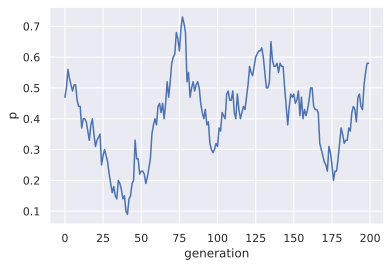

In [10]:
fig, ax = plt.subplots()
sns.lineplot(x='generation',y='p',data=df,legend=False)

As we can now see, the proportion of individuals with trait $A$ should start off hovering around $0.5$, and then oscillate randomly (it may, in some cases, also reach $0$, meaning that all of $A$ have disappeared, or $1$, meaning that all of $B$ have disappeared). Unbiased transmission, or random copying, is by definition random, so different runs of this simulation will generate different plots. If you rerun all the code you will get something different. In all likelihood, $p$ might go to $0$ or $1$ at some point. At $p=0$ there are no $A$ types and every individual possesses $B$. At $p=1$ there are no $B$ types and every individual possesses $A$. This is a typical feature of cultural drift, analogous to genetic drift: in small populations, with no selection or other directional processes operating, traits can be lost purely by chance after some generations.

## 1.4	Write a function to wrap the model code
Ideally, we would like to repeat the simulation to explore this idea in more detail, perhaps changing some of the parameters. For example, if we increase $N$, are we more or less likely to lose one of the traits? As noted above, agent-based models like this one are probabilistic or stochastic, thus it is essential to run simulations many times to understand what happens. With our code scattered about in chunks, it is hard to quickly repeat the simulation. Instead, we can wrap it all up in a function:

In [11]:
def unbiased_transmission_1(N,t_max):
	population = {i:random.choice(['A','B']) for i in range(0,N)}
	output = {g:0.0 for g in range(0,t_max)}
	total_A = sum(value == 'A' for value in population.values())
	output.update({0:total_A/N})

	for t in range(1,t_max):
		# Copy the variants from the previous generation 
		previous_population = list(population[i] for i in range(0,N))
		
		# Randomly copy from previous generation's individuals
		population = {i:random.sample(previous_population,k=1)[0] for i in range(0,N)}

		# Get p and put it into the dictionary at this generation t
		total_A = sum(value == 'A' for value in population.values())
		output.update({t:total_A/N})
	
	# Converts output dictionary to a pandas dataframe for plotting
	df = pd.DataFrame(output.items(), columns=['generation','p'])
	return df

This is identical to the code snippets that we already ran above, except now we're using a function with parameters $N$ and $t_{max}$ as arguments/parameters. In addition, `unbiased_transmission_1()` returns a dataframe `df` at the very end of the function. This gives us a dataset that we can use for plotting after the simulation has run.

Nothing will seem to happen when you run the code above, because all you have done is define the function and stored it in memory. The point is that we can now call the function in one go, easily changing the values of $N$ and $t_{max}$. Let's try first with the same values of $N$ and $t_{max}$ as before, and save the output from the simulation into `data_model`:

In [12]:
data_model = unbiased_transmission_1(N = 100, t_max = 200)
data_model

,generation,p
0,0,0.41
1,1,0.43
2,2,0.37
3,3,0.38
4,4,0.35
...,...,...
195,195,0.00
196,196,0.00
197,197,0.00
198,198,0.00


We also need to create another function to plot the data, so we do not need to rewrite all the plotting instructions each time. Whereas this may seem impractical now, it is convenient to separate the function that runs the simulation and the function that plots the data for various reasons. With more complicated models, we do not want to rerun a simulation just because we want to change some detail in the plot. It also makes conceptual sense to keep separate the raw output of the model from the various ways we can visualise it, or the further analysis we want to perform on it. As above, the code is identical to what we already wrote:

In [13]:
def plot_single_run(data_model):
	fig, ax = plt.subplots()
	ax.set_ylim(0.0,1.1)
	sns.lineplot(x='generation',y='p',data=data_model,legend=False)

At this point, we can visualise the results:

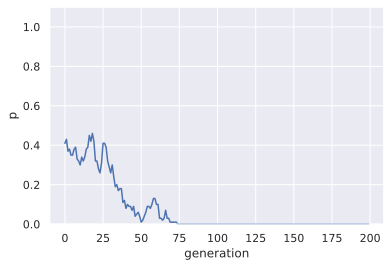

In [14]:
plot_single_run(data_model=data_model)

As anticipated, the plot is different from the simulation we ran before, even though the code is exactly the same. This is due to the stochastic nature of the simulation.

Now let’s try changing the parameters. We can call the simulation and the plotting functions together. The code below reruns and plots the simulation with a much larger $N$.

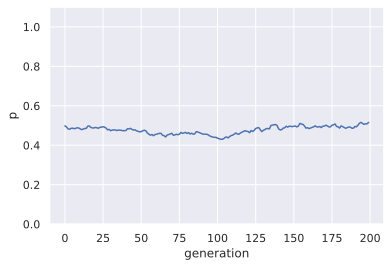

In [15]:
data_model = unbiased_transmission_1(N = 10000, t_max = 200)
plot_single_run(data_model=data_model)

You should see much less fluctuation. Rarely in a population of $N=10000$ will either trait go to fixation. Try re-running the previous code chunk to explore the effect of $N$ on long-term dynamics.

## 1.5	Run several independent simulations and plot their results
Wrapping a simulation in a function like this is good because we can easily re-run it with just a single command. However, it’s a bit laborious to manually re-run it. Say we wanted to re-run the simulation 10 times with the same parameter values to see how many times $A$ goes to fixation, and how many times $B$ goes to fixation. Currently, we’d have to manually run the `unbiased_transmission_1()` function 10 times and record somewhere else what happened in each run. It would be better to automatically re-run the simulation several times and plot each run as a separate line on the same plot.

Let's use a new parameter $r_{max}$ to specify the number of independent runs, and use another for-loop to cycle over the $r_{max}$ runs. Let's rewrite the `unbiased_transmission_1()` function to handle multiple runs. We will call the new function `unbiased_transmission_2()`.

FYI: In later lectures, we will learn how to use the processing cores on your computer to run multiple simulations simultaneously (i.e., in parallel), as opposed to running it sequentially one-by-one.  

In [16]:
def unbiased_transmission_2(N,t_max,r_max):
	df = pd.DataFrame(columns=['generation', 'p', 'run'])
	#For each run
	for r in range(0,r_max):
		population = {i:random.choice(['A','B']) for i in range(0,N)}
		output = {g:0.0 for g in range(0,t_max)}
		total_A = sum(value == 'A' for value in population.values())
		output.update({0:total_A/N})

		for t in range(1,t_max):
			# Copy the variants from the previous generation 
			previous_population = list(population[i] for i in range(0,N))
			
			# Randomly copy from previous generation's individuals
			population = {i:random.sample(previous_population,k=1)[0] for i in range(0,N)}

			# Get p and put it into the dictionary at this generation t
			total_A = sum(value == 'A' for value in population.values())
			output.update({t:total_A/N})

		run_list = [r for i in range(0,len(output))]
		a = pd.DataFrame(zip(output.keys(),output.values(),run_list), columns=['generation','p','run'])
		df = df.append(a,ignore_index=True)
	return df

There are a few minor alterations here. First, we need a different output, to accommodate the fact that we need to store data for all the runs in one place. For that, we initialise the same `generation` and `p` columns as before, but with an additional column `run` for all the runs. Second, we need a new loop, but this time it is executing over each run `for r in range(0,r_max)`.

The plotting function is also changed to handle multiple runs:

In [17]:
def plot_multiple_runs(data_model):
	fig, ax = plt.subplots()
	ax.set_ylim(0.0,1.1)
	sns.lineplot(x='generation',y='p',data=data_model,hue='run',legend=False)

All we've added is a new argument `hue='run'` which tells the lineplot function that we would like to have separate lines for each individual run in our model.

Let's now run the function and plot the results for five runs with the same parameters we used at the beginning ($N=100$ and $t_{max}=200$):

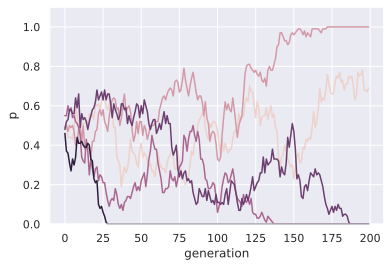

In [18]:
data_model = unbiased_transmission_2(N=100,t_max=200,r_max=5)
plot_multiple_runs(data_model=data_model)

You should see five independent runs of our simulation shown as different coloured lines. Some runs have probably gone to 0 or 1. The data is stored in `data_model`, which we can inspect by writing its name:

In [19]:
data_model

,generation,p,run
0,0,0.50,0
1,1,0.50,0
2,2,0.44,0
3,3,0.44,0
4,4,0.44,0
...,...,...,...
995,195,0.00,4
996,196,0.00,4
997,197,0.00,4
998,198,0.00,4


Now, let's run the `unbiased_transmission_2()` model with $N=10000$ to compare with $N=100$.

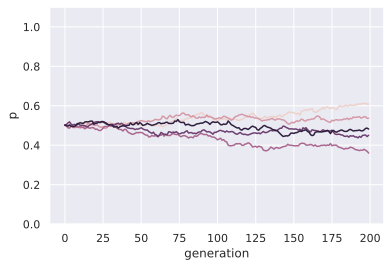

In [20]:
data_model = unbiased_transmission_2(N=10000,t_max=200,r_max=5)
plot_multiple_runs(data_model=data_model)

What you should see is that there is now *less variation* between runs, with most outcomes ending up around 0.5 (+/-0.10).

## 1.6	Varying initial conditions
Let's add one final modification. So far the starting frequencies of $A$ and $B$ have been the same, roughly 0.5 each. But what if we were to start at different initial frequencies of $A$ and $B$? Say, $p=0.2$ or $p=0.9$? Would unbiased transmission keep $p$ at these initial values, or would it go to $p=0.5$ as we have found so far?

To find out, we can add another parameter, `p_A`, which specifies the initial probability of an individual having an $A$ rather than a $B$ in the first generation. Previously this was always `p_A = 0.5`, but in the new function below we add it to the `random.choices()` function to weight the initial allocation of traits. 

In [21]:
def unbiased_transmission_3(N,p_A,t_max,r_max):
	df = pd.DataFrame(columns=['generation', 'p', 'run'])
	for r in range(0,r_max):
		population = {i:random.choices(['A','B'],k=1,weights=(p_A,1-p_A))[0] for i in range(0,N)}
		output = {g:0.0 for g in range(0,t_max)}
		total_A = sum(value == 'A' for value in population.values())
		output.update({0:total_A/N})

		for t in range(1,t_max):
			# Copy the variants from the previous generation 
			previous_population = list(population[i] for i in range(0,N))
			
			# Randomly copy from previous generation's individuals
			population = {i:random.sample(previous_population,k=1)[0] for i in range(0,N)}

			# Get p and put it into the dictionary at this generation t
			total_A = sum(value == 'A' for value in population.values())
			output.update({t:total_A/N})

		run_list = [r for i in range(0,len(output))]
		a = pd.DataFrame(zip(output.keys(),output.values(),run_list), columns=['generation','p','run'])
		df = df.append(a,ignore_index=True)
	return df

`unbiased_transmission_3()` is almost identical to the previous function. The only changes are the addition of $p_{A}$ as an argument to the function, and using it to set the weight in `random.choices()`. The `weight` argument gives the probability of picking each option, in our case $A$ and $B$, in the first generation. The probability of $A$ is now $p_{A}$, and the probability of $B$ is now $1 - p_{A}$. We can use the same plotting function as before to visualise the result. Let's see what happens with a different value of $p_{A}$, for example $p_{A}=0.2$

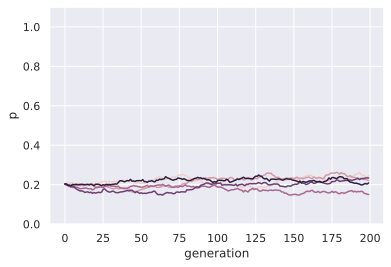

In [22]:
data_model = unbiased_transmission_3(N=10000,p_A=0.2,t_max=200,r_max=5)
plot_multiple_runs(data_model)

With $p_{A}=0.2$, trait frequencies stay at $p=0.2$. Unbiased transmission is truly non-directional: it maintains trait frequencies at whatever they were in the previous generation, barring random fluctuations caused by small population sizes.

## 1.7	Summary of the model
Even this extremely simple model provides some valuable insights. First, unbiased transmission does not in itself change trait frequencies. As long as populations are large, trait frequencies remain the same.

Second, the smaller the population size, the more likely traits are to be lost by chance. This is a basic insight from population genetics, known there as genetic drift, but it can also be applied to cultural evolution. Many studies have tested (and some supported) the idea that population size and other demographic factors can shape cultural diversity.

Furthermore, generating expectations about cultural change under simple assumptions like random cultural drift can be useful for detecting non-random patterns like selection. If we don’t have a baseline, we won't know selection or other directional processes when we see them.

We have also introduced several programming techniques that will be useful in later simulations. We have seen how to use lists, dictionaries, and pandas dataframes to hold characteristics of individuals and the outputs of simulations, how to use loops to cycle through generations and simulation runs, how to use `random.choices()` to pick randomly from sets of elements, how to wrap simulations in functions to easily re-run them with different parameter values, and how to use matplotlib and seaborn to plot the results of simulations.